<a href="https://colab.research.google.com/github/Shashanth27/imageprocessing/blob/main/Satellite_Imagery_DeepLearning_Base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install patchify

In [ ]:
import os
import cv2
from PIL import Image
import numpy as np
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from matplotlib import pyplot as plt
import random

In [ ]:
minmaxscaler = MinMaxScaler()

In [ ]:
dataset_root_folder = '/content/drive/MyDrive/Colab Notebooks/'

In [ ]:
dataset_name = "idk"

In [ ]:
size = 256

In [ ]:
imagedataset = []
maskdataset = []

for imagetype in ['images' , 'masks']:
  if imagetype == 'images':
    extension = 'jpg'
  elif imagetype == 'masks':
     extension = 'png'
  for tile_id in range(1,8):
    for image_id in range(1,20):
      image = cv2.imread(f'{dataset_root_folder}/{dataset_name}/Tile {tile_id}/{imagetype}/image_part_00{image_id}.{extension}',1)
      if image is not None:
        if imagetype == 'masks':
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #print(image.shape)
        x = (image.shape[1]//size)*size
        y = (image.shape[0]//size)*size
        #print("{} --- {} - {}".format(image.shape, x, y))
        image = Image.fromarray(image)
        image = image.crop((0,0, x, y))
        #print("({},  {})".format(image.size[0],image.size[1]))
        image = np.array(image)
        patched_images = patchify(image, (size, size, 3),step=size)
        #print(len(patched_images))
        for i in range(patched_images.shape[0]):
          for j in range(patched_images.shape[1]):
            if imagetype == 'images':
              individual_patched_image = patched_images[i,j,:,:]
              #print(individual_patched_image.shape)
              individual_patched_image = minmaxscaler.fit_transform(individual_patched_image.reshape(-1, individual_patched_image.shape[-1])).reshape(individual_patched_image.shape)
              individual_patched_image = individual_patched_image[0]
              #print(individual_patched_image.shape)
              imagedataset.append(individual_patched_image)
            elif imagetype == 'masks':
              individual_patched_mask = patched_images[i,j,:,:]
              individual_patched_mask = individual_patched_mask[0]
              maskdataset.append(individual_patched_mask)


In [ ]:
imagedataset = np.array(imagedataset)
maskdataset = np.array(maskdataset)

In [ ]:
print(len(imagedataset))
print(len(maskdataset))

NameError: name 'imagedataset' is not defined

In [ ]:
building = '#3C1098'
building = building.lstrip('#')
building = np.array(tuple(int(building[i:i+2], 16) for i in (0,2,4)))
print(building)

land = '#8429F6'
land = land.lstrip('#')
land = np.array(tuple(int(land[i:i+2], 16) for i in (0,2,4)))
print(land)

road = '#6EC1E4'
road = road.lstrip('#')
road = np.array(tuple(int(road[i:i+2], 16) for i in (0,2,4)))
print(road)

vegetation = '#FEDD3A'
vegetation = vegetation.lstrip('#')
vegetation = np.array(tuple(int(vegetation[i:i+2], 16) for i in (0,2,4)))
print(vegetation)

water = '#E2A929'
water = water.lstrip('#')
water = np.array(tuple(int(water[i:i+2], 16) for i in (0,2,4)))
print(water)

unlabeled = '#9B9B9B'
unlabeled = unlabeled.lstrip('#')
unlabeled = np.array(tuple(int(unlabeled[i:i+2], 16) for i in (0,2,4)))
print(unlabeled)

[ 60  16 152]
[132  41 246]
[110 193 228]
[254 221  58]
[226 169  41]
[155 155 155]


In [ ]:
def rgb(label):
  label_segment = np.zeros(label.shape, dtype=np.uint8)
  label_segment[np.all(label == water, axis=-1)] = 0
  label_segment[np.all(label == land, axis=-1)] = 1
  label_segment[np.all(label == road, axis=-1)] = 2
  label_segment[np.all(label == building, axis=-1)] = 3
  label_segment[np.all(label == vegetation, axis=-1)] = 4
  label_segment[np.all(label == unlabeled, axis=-1)] = 5
  #print(label_segment)
  label_segment = label_segment[:,:,0]
  #print(label_segment)
  return label_segment

In [ ]:
labels = []
for i in range(maskdataset.shape[0]):
  label = rgb(maskdataset[i])
  labels.append(label)

In [ ]:
labels = np.array(labels)
labels = np.expand_dims(labels, axis=3)

In [ ]:
np.unique(labels)

array([0, 1, 2, 3, 4, 5], dtype=uint8)

In [ ]:
print("Total unique labels based on masks: ",format(np.unique(labels)))

Total unique labels based on masks:  [0 1 2 3 4 5]


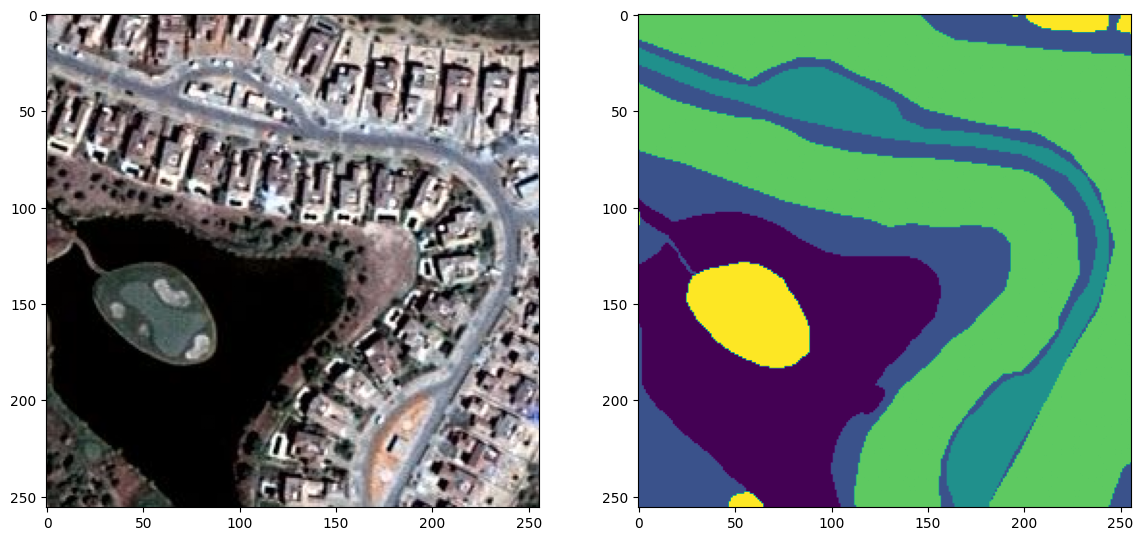

In [ ]:
r = random.randint(0, len(imagedataset))

plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(imagedataset[r])
plt.subplot(122)
#plt.imshow(maskdataset[r])
plt.imshow(labels[r][:,:,0])

In [ ]:
total_classes = len(np.unique(labels))

In [ ]:
total_classes

6

In [ ]:
from tensorflow.keras.utils import to_categorical

In [ ]:
labels_categorical_dataset = to_categorical(labels, num_classes=total_classes)

In [ ]:
master_trianing_dataset = imagedataset

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(master_trianing_dataset, labels_categorical_dataset, test_size=0.15, random_state=100)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(803, 256, 256, 3)
(142, 256, 256, 3)
(803, 256, 256, 6)
(142, 256, 256, 6)


In [ ]:
imageheight = X_train.shape[1]
imagewidth = X_train.shape[2]
imagechannels = X_train.shape[3]
totalclasses = y_train.shape[3]

In [ ]:
print(imageheight)
print(imagewidth)
print(imagechannels)
print(totalclasses)

NameError: name 'imageheight' is not defined

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda


In [ ]:
from keras import backend as k


In [ ]:
def jaccard(y_true, y_pred):
     y_true_flatten =k.flatten(y_true)
     y_pred_flatten=k.flatten(y_pred)
     intersection=k.sum(y_true_flatten*y_pred_flatten)
     finalvalue= intersection + 1.0/(k.sum(y_true_flatten)+k.sum(y_pred_flatten)-intersection+1.0)
     return finalvalue



In [ ]:
def muitiunetmodel(n_classes=5,imageheight=256, imagewidth=256, imagechannels=1):
  input = Input((imageheight,imagewidth,imagechannels))
  sinput=input
  c1 = Conv2D(16, (3,3), activation='relu',kernel_initializer='he_normal', padding='same')(sinput)
  c1=Dropout(0.2)(c1)
  c1 = Conv2D(16, (3,3), activation='relu',kernel_initializer='he_normal', padding='same')(c1)
  p1=MaxPooling2D((2,2))(c1)

  c2 = Conv2D(32, (3,3), activation='relu',kernel_initializer='he_normal', padding='same')(p1)
  c2=Dropout(0.2)(c2)
  c2 = Conv2D(32, (3,3), activation='relu',kernel_initializer='he_normal', padding='same')(c2)
  p2=MaxPooling2D((2,2))(c2)

  c3=Conv2D(64, (3,3), activation='relu',kernel_initializer='he_normal', padding='same')(p2)
  c3=Dropout(0.2)(c3)
  c3 = Conv2D(64, (3,3), activation='relu',kernel_initializer='he_normal', padding='same')(c3)
  p3=MaxPooling2D((2,2))(c3)

  c4=Conv2D(128, (3,3), activation='relu',kernel_initializer='he_normal', padding='same')(p3)
  c4=Dropout(0.2)(c4)
  c4 = Conv2D(128, (3,3), activation='relu',kernel_initializer='he_normal', padding='same')(c4)
  p4=MaxPooling2D((2,2))(c4)

  c5=Conv2D(256, (3,3), activation='relu',kernel_initializer='he_normal', padding='same')(p4)
  c5=Dropout(0.2)(c5)
  c5 = Conv2D(256, (3,3), activation='relu',kernel_initializer='he_normal', padding='same')(c5)
  p5=MaxPooling2D((2,2))(c5)

  u6=Conv2DTranspose(128,(2,2),strides=(2,2),padding='same')(c5)
  u6=concatenate([u6,c4])
  c6=Conv2D(128, (3,3), activation='relu',kernel_initializer='he_normal', padding='same')(u6)
  c6=Dropout(0.2)(c6)
  c6 = Conv2D(128, (3,3), activation='relu',kernel_initializer='he_normal', padding='same')(c6)

  u7=Conv2DTranspose(64,(2,2),strides=(2,2),padding='same')(c6)
  u7=concatenate([u7,c3])
  c7=Conv2D(64, (3,3), activation='relu',kernel_initializer='he_normal', padding='same')(u7)
  c7=Dropout(0.2)(c7)
  c7 = Conv2D(64, (3,3), activation='relu',kernel_initializer='he_normal', padding='same')(c7)

  u8=Conv2DTranspose(32,(2,2),strides=(2,2),padding='same')(c7)
  u8=concatenate([u8,c2])
  c8=Conv2D(32, (3,3), activation='relu',kernel_initializer='he_normal', padding='same')(u8)
  c8=Dropout(0.2)(c8)
  c8 = Conv2D(32, (3,3), activation='relu',kernel_initializer='he_normal', padding='same')(c8)

  u9=Conv2DTranspose(16,(2,2),strides=(2,2),padding='same')(c8)
  u9=concatenate([u9,c1],axis=3)
  c9=Conv2D(16, (3,3), activation='relu',kernel_initializer='he_normal', padding='same')(u9)
  c9=Dropout(0.2)(c9)
  c9 = Conv2D(16, (3,3), activation='relu',kernel_initializer='he_normal', padding='same')(c9)

  output=Conv2D(n_classes, (1,1), activation='softmax')(c9)
  model=Model(input, output)
  return model










In [ ]:
metrics=['accuracy', jaccard]

In [ ]:
def deeplearnigmodel():
  return muitiunetmodel(n_classes=totalclasses,imageheight=imageheight, imagewidth=imagewidth, imagechannels=imagechannels)

In [ ]:
model=deeplearnigmodel()


In [ ]:
model.get_config()

{'name': 'functional',
 'trainable': True,
 'layers': [{'module': 'keras.layers',
   'class_name': 'InputLayer',
   'config': {'batch_shape': (None, 256, 256, 3),
    'dtype': 'float32',
    'sparse': False,
    'name': 'input_layer'},
   'registered_name': None,
   'name': 'input_layer',
   'inbound_nodes': []},
  {'module': 'keras.layers',
   'class_name': 'Conv2D',
   'config': {'name': 'conv2d',
    'trainable': True,
    'dtype': {'module': 'keras',
     'class_name': 'DTypePolicy',
     'config': {'name': 'float32'},
     'registered_name': None},
    'filters': 16,
    'kernel_size': (3, 3),
    'strides': (1, 1),
    'padding': 'same',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'groups': 1,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'module': 'keras.initializers',
     'class_name': 'HeNormal',
     'config': {'seed': None},
     'registered_name': None},
    'bias_initializer': {'module': 'keras.initializers',
     'cla

In [ ]:
weight=[0.166,0.166,0.166,0.166,0.166,0.166]

In [ ]:
!pip install segmentation_models

  Using cached efficientnet-1.0.0-py3-none-any.whl.metadata (6.1 kB)
Using cached efficientnet-1.0.0-py3-none-any.whl (17 kB)
  Attempting uninstall: efficientnet
    Found existing installation: efficientnet 1.1.1
    Uninstalling efficientnet-1.1.1:
      Successfully uninstalled efficientnet-1.1.1


In [ ]:


import segmentation_models as sm

Segmentation Models: using `keras` framework.


In [ ]:
diceloss=sm.losses.DiceLoss(weight)
focalloss=sm.losses.CategoricalFocalLoss()
totalloss=diceloss+(1*focalloss)


In [ ]:
import tensorflow as tf
tf.keras.backend.clear_session()

In [ ]:
model.compile(optimizer='adam', loss=totalloss, metrics=metrics)

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 16)   │            448 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256, 256, 16)   │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 16)   │          2,320 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 16)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 32)   │          4,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128, 128, 32)   │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 32)   │          9,248 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 32)     │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 64)     │         18,496 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 64, 64, 64)     │              0 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 64)     │         36,928 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 64)     │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 128)    │         73,856 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 32, 32, 128)    │              0 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 128)    │        147,584 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 16, 16, 128)    │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)    

 Total params: 1,941,190 (7.41 MB)

 Trainable params: 1,941,190 (7.41 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
modelhistory=model.fit(X_train, y_train, validation_data=(X_test, y_test),verbose=1, batch_size=16, epochs=10,shuffle=False)